

The 10-Step Machine Learning Pipeline (My Version):
1. Define business object
2. Make sense of the data from a high level
    - data types (number, text, object, etc.)
    - continuous/discrete
    - scales and distributions of different features
3. Create the traning and test sets using proper sampling methods, e.g., random vs. stratified
4. Correlation analysis (pair-wise and attribute combinations)
5. Data cleaning (missing data, outliers, data errors)
6. Data transformation via pipelines (categorical text to number using dummy variables, feature scaling via normalization/standardization, feature combinations)
7. Train and cross validate different models and select the most promising one (Linear Regression, Lasso, and Random Forest were tried in this tutorial)
8. Fine tune the model using trying different combinations of hyperparameters
9. Evaluate the model with best estimators in the test set
10. Launch, monitor, and refresh the model and system

In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [2]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')


In [3]:
##display the first five rows of the test dataset.
test.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
#train.describe()#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


## Make Sence of the Data
What are the typical things we can learn from the basic statistics with visualizaitons? 
1. Do the data make sence? scan each column and see whether the data make sense at a high level. 
    
    -  house value data is OK and this is our target variable, i.e., we want to build a model to predict this value.
 
2. Feature scaling: you have noticed that the features have very different scales, which we need to handle later
3. Distribution: from the histograms, we can tell many of them are skewed, i.e., having a long tail on one side or the other. In many cases, we need to transform the data so that they have more bell-shaped distributions.

Normality Test

Text(0.5, 1.0, 'SalePrice distribution')

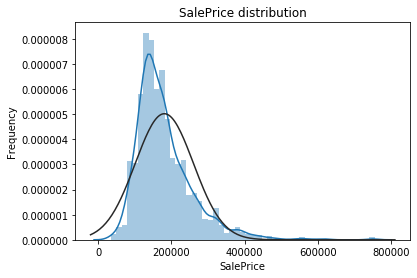

In [5]:
sns.distplot(train['SalePrice'] , fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# #Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(train['SalePrice'], plot=plt)
# plt.show()

#Data Processing

Target Variable: SalePrice

Text(0.5, 1.0, 'SalePrice distribution')

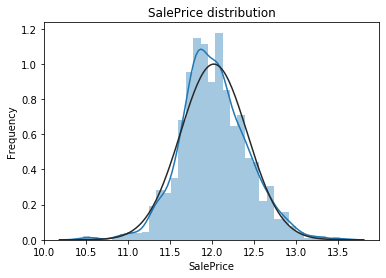

In [6]:
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# #Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(train['SalePrice'], plot=plt)
# plt.show()

Correlated Variables

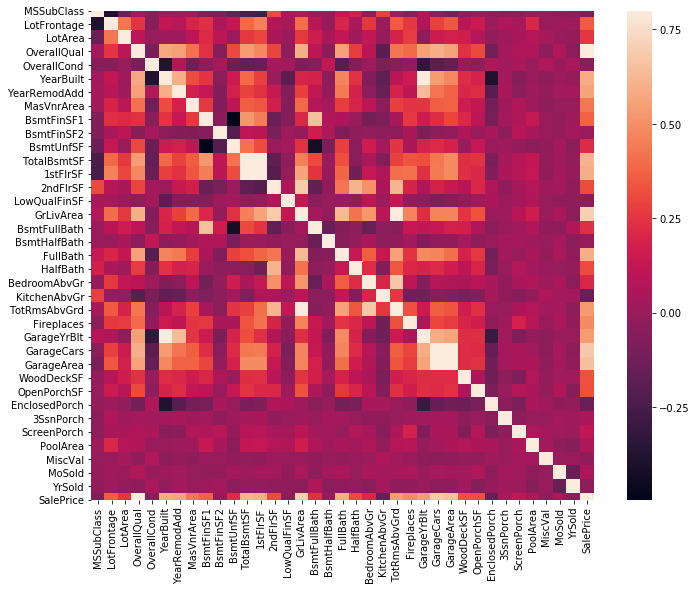

In [7]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

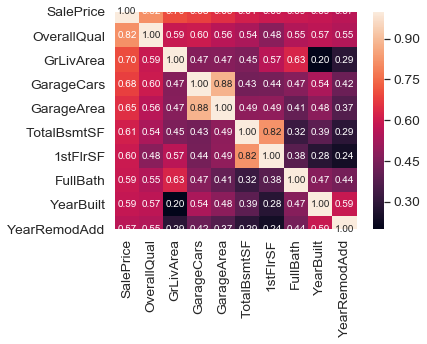

In [8]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

C:\Users\Long Chen\Anaconda3\envs\py3.6\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


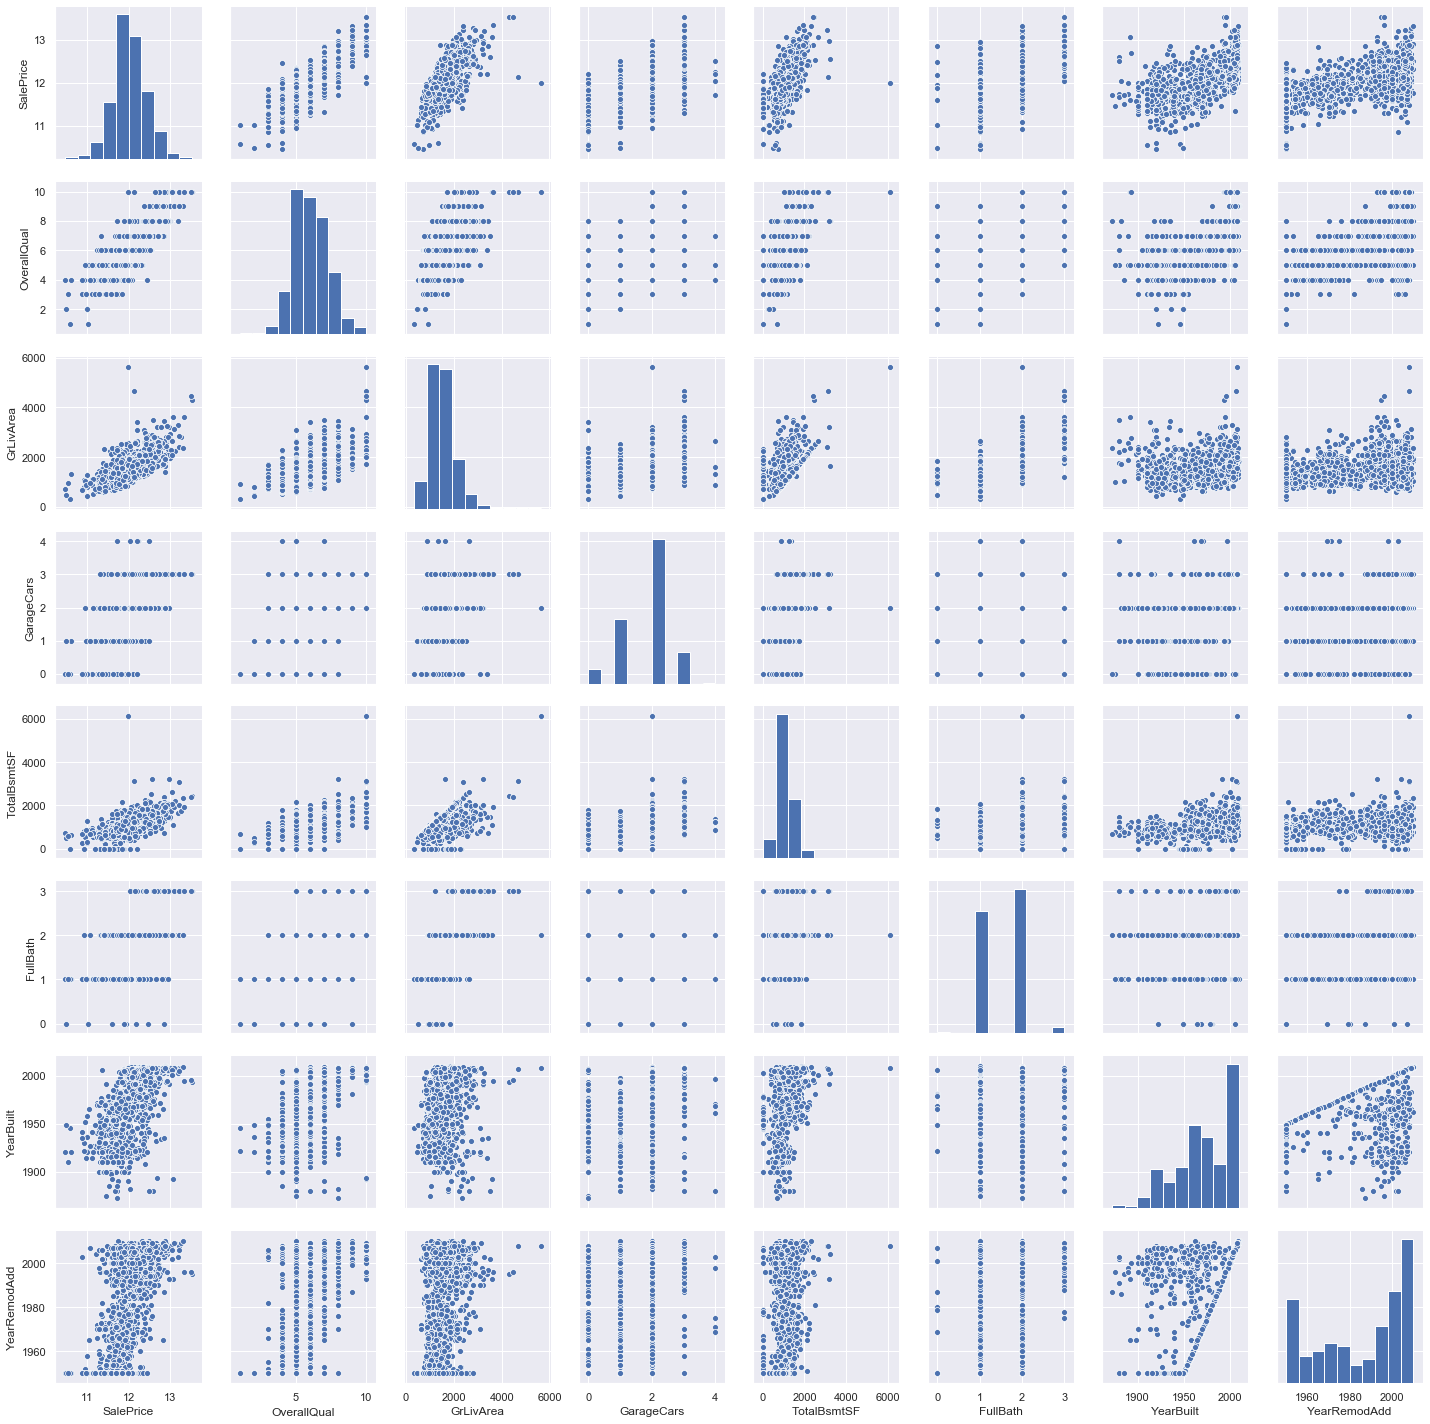

In [9]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt','YearRemodAdd']
sns.pairplot(train[cols], size = 2.5)
plt.show();

Missing Data

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
#all_data = all_data[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt','YearRemodAdd']]
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


C:\Users\Long Chen\Anaconda3\envs\py3.6\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [11]:
print(all_data.shape)

(2919, 79)


In [12]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageCond,5.447071
GarageFinish,5.447071
GarageYrBlt,5.447071


Text(0.5, 1.0, 'Percent missing data by feature')

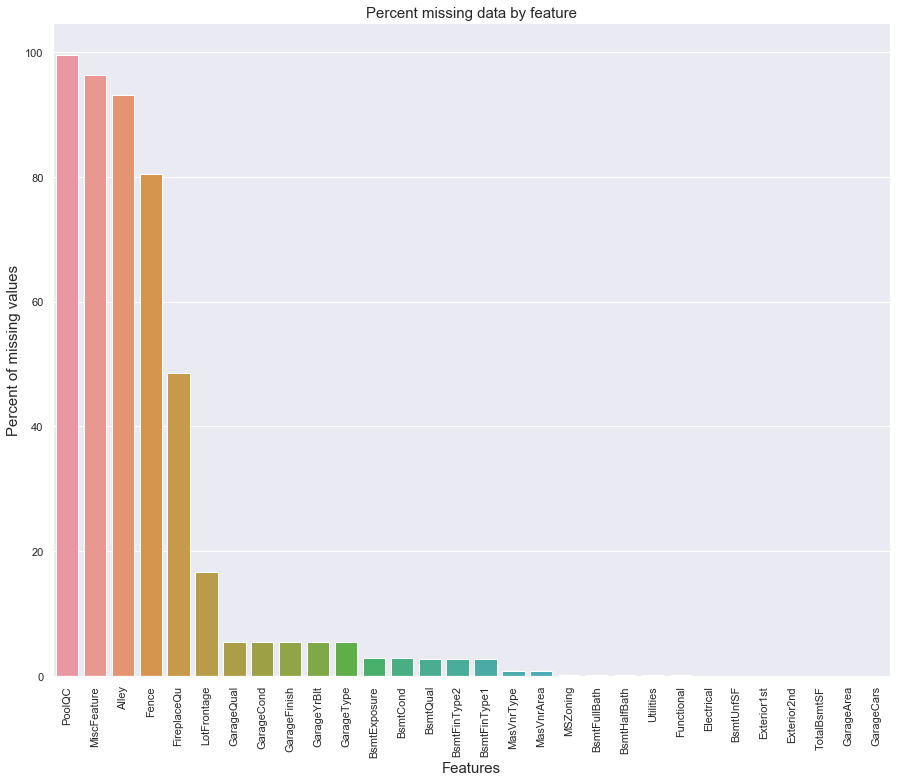

In [13]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [14]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797


In [15]:
all_data = all_data.drop(['Utilities'], axis=1)

In [17]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',):
    all_data[col] = all_data[col].fillna(0)
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [18]:
#all_data = all_data.fillna(0)

In [19]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [20]:
print(all_data.shape)

(2919, 78)


In [21]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [22]:
from sklearn.preprocessing import LabelEncoder
cols = (   
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 
         'Functional',   'LandSlope',
        'LotShape', 'PavedDrive', 'Street',  'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 78)


In [23]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# outliers

Let's explore these outliers


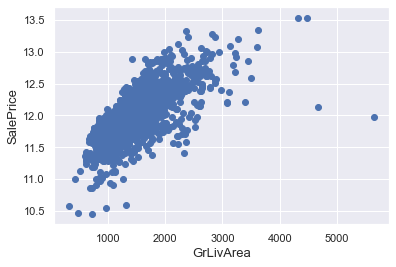

In [24]:

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

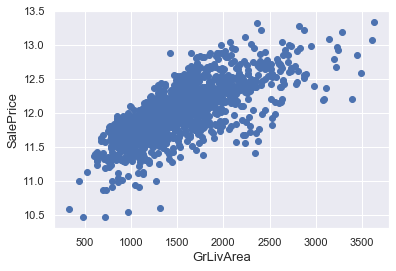

In [25]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
# train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']>700000)].index)
#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

###Note : 
 Outliers removal is note always safe.  We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. 

##Target Variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.

The skew seems now corrected and the data appears more normally distributed. 

##Features engineering

let's first  concatenate the train and test data in the same dataframe

**Getting dummy categorical features**

In [26]:

all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 272)


In [27]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,CentralAir,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,856,854,0,3,706.0,0.0,1.0,0.0,150.0,1,...,0,0,0,0,0,0,0,0,0,1
1,1262,0,0,3,978.0,0.0,0.0,1.0,284.0,1,...,0,0,0,0,0,0,0,0,0,1
2,920,866,0,3,486.0,0.0,1.0,0.0,434.0,1,...,0,0,0,0,0,0,0,0,0,1
3,961,756,0,3,216.0,0.0,1.0,0.0,540.0,1,...,0,0,0,0,0,0,0,0,0,1
4,1145,1053,0,4,655.0,0.0,1.0,0.0,490.0,1,...,0,0,0,0,0,0,0,0,0,1


Getting the new train and test sets. 

Regularization

This is a form of regression, that constrains/ regularizes or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, so as to avoid the risk of overfitting.

A simple relation for linear regression looks like this. Here Y represents the learned relation and β represents the coefficient estimates for different variables or predictors(X).

# Linear Regression

Y ≈ β0 + β1X1 + β2X2 + … + βpXp

The fitting procedure involves a loss function, known as residual sum of squares or RSS. The coefficients are chosen, such that they minimize this loss function.

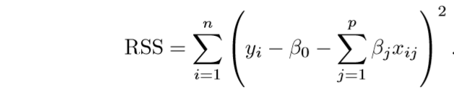

# Ridge


Now, this will adjust the coefficients based on your training data. If there is noise in the training data, then the estimated coefficients won’t generalize well to the future data. This is where regularization comes in and shrinks or regularizes these learned estimates towards zero.



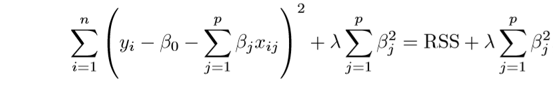



Above image shows ridge regression, where the RSS is modified by adding the shrinkage quantity. Now, the coefficients are estimated by minimizing this function. Here, λ is the tuning parameter that decides how much we want to penalize the flexibility of our model. The increase in flexibility of a model is represented by increase in its coefficients, and if we want to minimize the above function, then these coefficients need to be small. This is how the Ridge regression technique prevents coefficients from rising too high. Also, notice that we shrink the estimated association of each variable with the response, except the intercept β0, This intercept is a measure of the mean value of the response when xi1 = xi2 = …= xip = 0.

When λ = 0, the penalty term has no effect, and the estimates produced by ridge regression will be equal to least squares. However, as λ→∞, the impact of the shrinkage penalty grows, and the ridge regression coefficient estimates will approach zero. As can be seen, selecting a good value of λ is critical. Cross validation comes in handy for this purpose. The coefficient estimates produced by this method are also known as the L2 norm.

# Lasso

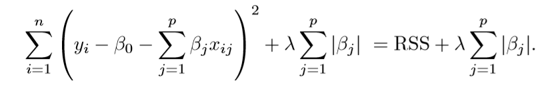

Lasso is another variation, in which the above function is minimized. Its clear that this variation differs from ridge regression only in penalizing the high coefficients. It uses |βj| (modulus)instead of squares of β, as its penalty. In statistics, this is known as the L1 norm.

Lets take a look at above methods with a different perspective. The ridge regression can be thought of as solving an equation, where summation of squares of coefficients is less than or equal to s. And the Lasso can be thought of as an equation where summation of modulus of coefficients is less than or equal to s. Here, s is a constant that exists for each value of shrinkage factor λ. These equations are also referred to as constraint functions.

Consider their are 2 parameters in a given problem. Then according to above formulation, the ridge regression is expressed by β1² + β2² ≤ s. This implies that ridge regression coefficients have the smallest RSS(loss function) for all points that lie within the circle given by β1² + β2² ≤ s.

Similarly, for lasso, the equation becomes,|β1|+|β2|≤ s. This implies that lasso coefficients have the smallest RSS(loss function) for all points that lie within the diamond given by |β1|+|β2|≤ s.


The above image shows the constraint functions(green areas), for lasso (left) and ridge regression (right), along with contours for RSS (red ellipse). Points on the ellipse share the value of RSS. For a very large value of s, the green regions will contain the center of the ellipse, making coefficient estimates of both regression techniques, equal to the least squares estimates. But, this is not the case in the above image. In this case, the lasso and ridge regression coefficient estimates are given by the first point at which an ellipse contacts the constraint region. Since ridge regression has a circular constraint with no sharp points, this intersection will not generally occur on an axis, and so the ridge regression coefficient estimates will be exclusively non-zero.
However, the lasso constraint has corners at each of the axes, and so the ellipse will often intersect the constraint region at an axis. When this occurs, one of the coefficients will equal zero. In higher dimensions(where parameters are much more than 2), many of the coefficient estimates may equal zero simultaneously.

This sheds light on the obvious disadvantage of ridge regression, which is model interpretability. It will shrink the coefficients for least important predictors, very close to zero. But it will never make them exactly zero. In other words, the final model will include all predictors. However, in the case of the lasso, the L1 penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter λ is sufficiently large. Therefore, the lasso method also performs variable selection and is said to yield sparse models.

What does Regularization achieve?

A standard least squares model tends to have some variance in it, i.e. this model won’t generalize well for a data set different than its training data. Regularization, significantly reduces the variance of the model, without substantial increase in its bias. So the tuning parameter λ, used in the regularization techniques described above, controls the impact on bias and variance. As the value of λ rises, it reduces the value of coefficients and thus reducing the variance. Till a point, this increase in λ is beneficial as it is only reducing the variance(hence avoiding overfitting), without loosing any important properties in the data. But after certain value, the model starts loosing important properties, giving rise to bias in the model and thus underfitting. Therefore, the value of λ should be carefully selected.

This is all the basic you will need, to get started with Regularization. It is a useful technique that can help in improving the accuracy of your regression models. A popular library for implementing these algorithms is Scikit-Learn. It has a wonderful API that can get your model up an running with just a few lines of code in python.

In [28]:
train = all_data[:ntrain]
test = all_data[ntrain:]


In [29]:
!pip install lightgbm

  Using cached https://files.pythonhosted.org/packages/1f/cb/a8ec24334c35a7d0c87b4e4e056bd2137573c7c1bd81c760b79a2f370254/lightgbm-2.3.1-py2.py3-none-win_amd64.whl


#Modelling

**Import librairies**

In [41]:
#!pip install xgboost
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb



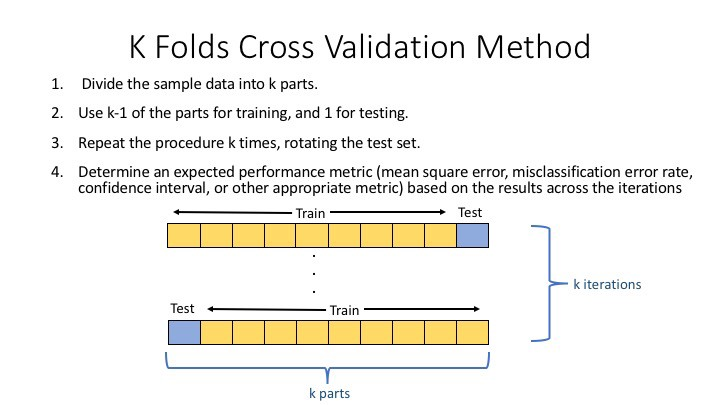

We use the **cross_val_score** function of Sklearn. However this function has not a shuffle attribut, we add then one line of code,  in order to shuffle the dataset  prior to cross-validation

In [32]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features': [15,30,45,100,120,140,160,180,195]},  # try 3x9=27 combinations
    {'bootstrap': [False], 'n_estimators':[3, 10], 'max_features': [2, 3, 4]},  # try 2x3=6 combinations
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')  # each model is trained 5 times, so (12+6)*5 = 80 rounds of training in total
grid_search.fit(train.values, y_train)
grid_search.best_params_  # best parameters

{'max_features': 120, 'n_estimators': 30}

In [34]:
grid_search.best_estimator_ 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=120, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

##Base models

In [35]:
rf = make_pipeline(RobustScaler(), grid_search.best_estimator_)

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline 

In [36]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Elastic Net Regression** :

again made robust to outliers

In [37]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression** :

In [42]:
KRR = Ridge()

- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers
    

In [43]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- **XGBoost** :

In [44]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)



- **LightGBM** :

In [45]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

###Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error

In [46]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1365 (0.0291)



In [47]:
score = rmsle_cv(rf)
print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Random Forest score: 0.1372 (0.0107)



In [48]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1365 (0.0288)



In [49]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1438 (0.0251)



In [50]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1240 (0.0124)



In [51]:

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1220 (0.0095)



In [52]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1213 (0.0096)



##Stacking  models

###Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn with our model and also to laverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In [53]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

We just average four models here **ENet, GBoost,  KRR and lasso**.  Of course we could easily add more models in the mix. 

In [ ]:
averaged_models = AveragingModels(models = (model_lgb, GBoost, model_xgb, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

**Stacking averaged Models Class**

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Stacking Averaged models Score**

To make the two approaches comparable (by using the same number of models) , we just average **LGB, XGB, and Gboost**, then we add **lasso as meta-model**.

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (model_lgb, GBoost, model_xgb),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

We get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the** StackedRegressor** defined previously. 

We first define a rmsle evaluation function 

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

###Final Training and Prediction

**StackedRegressor:**

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

**XGBoost:**

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

**LightGBM:**

In [ ]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

In [ ]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.8 +
               xgb_train_pred*0.1 + lgb_train_pred*0.1 ))

**Ensemble prediction:**

In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

**Submission**

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)